# 拉勾网数据分析师招聘信息分析

最近想在深圳找一个数据分析的岗位，凭借这段时间学习的爬虫知识和机器学习知识，小试牛刀一把。

先利用scrapy爬虫框架爬取了拉勾网发布的所有深圳的数据分析师招聘信息，并保存为text格式

数据的每一行都是一个json格式，现在用pandas读取进来，做一个数据探索分析（EDA)。

In [1]:
# 载入必要的包文件
import pandas as pd
from toolz import pipe
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
sns.set(style='white')
from plotnine import *
from plydata import *
from collections import Counter
from pyecharts import Pie, WordCloud
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### 数据读取与清洗

In [2]:
file_path = r"C:\Users\lhs\Desktop\TEMP\Web Scraping\lagou data analyst\lagou\final_result.csv"
df_origin = pd.read_csv(file_path)
df_origin.head()

,Unnamed: 0,content
0,0,"{'companyId': 33627, 'positionName': '数据分析', '..."
1,1,"{'companyId': 434092, 'positionName': '数据分析', ..."
2,2,"{'companyId': 214114, 'positionName': '数据分析师',..."
3,3,"{'companyId': 135283, 'positionName': '数据分析师',..."
4,4,"{'companyId': 115706, 'positionName': '数据分析师',..."


In [3]:
df_json = df_origin[['content']]
df_json.head()

,content
0,"{'companyId': 33627, 'positionName': '数据分析', '..."
1,"{'companyId': 434092, 'positionName': '数据分析', ..."
2,"{'companyId': 214114, 'positionName': '数据分析师',..."
3,"{'companyId': 135283, 'positionName': '数据分析师',..."
4,"{'companyId': 115706, 'positionName': '数据分析师',..."


可以看到每一行都是一个json文本，我们需要把每一行的文本展开，变成一个标准的数据框。

但是每行的json文本并不严格满足json的定义，需要进行清洗。

In [4]:
# 定义一个清洗函数
def parse_json(string):
    '''
    ::str -> Dict
    
    string: 需要处理的字符串
    
    return: Dict
    '''
    string = (string
              .replace("'", '"') # 单引号替换成双引号
              .replace('""', "")
              .replace("None", '""') # None替换成""
              .replace("\'", "\"") # /替换成""
              .replace("[]", '""') # []替换成""
             ) 
    try:
        result = json.loads(string)
    except:
        return "Failed"
    else:
        return result

In [5]:
# 将清洗后的数据赋值给新的数据框
df = pd.DataFrame()
df['content'] = df_json['content'].apply(parse_json)

查看清晰失败的数据，发现全部都清洗成功了！

In [6]:
df[df.content == "Failed"]

,content


In [7]:
df.head()

,content
0,"{'companyId': 33627, 'positionName': '数据分析', '..."
1,"{'companyId': 434092, 'positionName': '数据分析', ..."
2,"{'companyId': 214114, 'positionName': '数据分析师',..."
3,"{'companyId': 135283, 'positionName': '数据分析师',..."
4,"{'companyId': 115706, 'positionName': '数据分析师',..."


我们看一下一条数据里面包含了哪些信息

In [8]:
a_entry = df.loc[0].values[0].keys()
attrs = list(a_entry)
attrs

['companyId',
 'positionName',
 'workYear',
 'education',
 'jobNature',
 'financeStage',
 'companySize',
 'companyLogo',
 'industryField',
 'city',
 'salary',
 'companyShortName',
 'positionId',
 'positionAdvantage',
 'createTime',
 'district',
 'score',
 'approve',
 'positionLables',
 'industryLables',
 'publisherId',
 'companyLabelList',
 'businessZones',
 'longitude',
 'latitude',
 'formatCreateTime',
 'companyFullName',
 'adWord',
 'hitags',
 'resumeProcessRate',
 'resumeProcessDay',
 'imState',
 'lastLogin',
 'explain',
 'plus',
 'pcShow',
 'appShow',
 'deliver',
 'gradeDescription',
 'promotionScoreExplain',
 'firstType',
 'secondType',
 'isSchoolJob',
 'subwayline',
 'stationname',
 'linestaion',
 'thirdType',
 'skillLables']

一个整洁的数据框就是每一行代表一个观测，每一列代表这个观测的属性。

接下来将清洗过的数据框，转化成整洁的数据框。

In [9]:

def to_df(entry):
    a_df = pd.DataFrame()
    attrs = list()
    values = list()
    for attr, value in entry.items():
        if type(value) is list:
            value = ','.join(value)
        if value is "":
            value = np.NaN
        a_df[attr] = [value]
    return a_df

In [10]:
df['df'] = df['content'].apply(to_df)
df.tail()

,content,df
282,"{'positionAdvantage': '挑战大，大牛领导，有价值的项目', 'sala...",positionAdvantage salary companyId long...
283,"{'positionAdvantage': '五险一金', 'salary': '10k-1...",positionAdvantage salary companyId long...
284,"{'positionAdvantage': '发展前景', 'salary': '15k-3...",positionAdvantage salary companyId long...
285,"{'positionAdvantage': '大数据,信用卡,海量数据,银行', 'sala...",positionAdvantage salary companyId long...
286,"{'positionAdvantage': '4A公司,平台好,晋升快', 'salary'...",positionAdvantage salary companyId longitu...


In [11]:
df_cleaned = pd.concat(df.df.values, sort=True)
df_cleaned = df_cleaned.reset_index().drop('index', axis=1)
df_cleaned.head()

,adWord,appShow,approve,businessZones,city,companyFullName,companyId,companyLabelList,companyLogo,companyShortName,...,resumeProcessDay,resumeProcessRate,salary,score,secondType,skillLables,stationname,subwayline,thirdType,workYear
0,0,0,1,NaN,深圳,深圳市乐易网络股份有限公司,33627,"技术大牛,两次年度旅游,福利倍儿好,年终奖丰厚",i/image/M00/57/05/CgqKkVfOIv6AQwyPAAEg94dso0Q1...,乐易网络,...,0,100,10k-20k,0,数据开发,"MySQL,SQLServer",深大,2号线/蛇口线,数据分析,1-3年
1,0,0,1,NaN,深圳,五八生活圈（深圳）科技有限公司,434092,NaN,i/image2/M01/7A/DC/CgoB5ltxI9SACWurAABPuq3ElYU...,五八生活圈（深圳）科技有限公司,...,0,0,15k-25k,0,运营,NaN,上水径,5号线/环中线,数据运营,3-5年
2,0,0,1,NaN,深圳,上海懒人易健科技有限公司,214114,NaN,i/image3/M00/54/04/Cgq2xlsPjQWAIPR1AAAd0T_4rzQ...,懒人科技,...,1,35,15k-27k,0,数据分析,"BI,数据运营,SQL",NaN,NaN,BI,3-5年
3,0,0,1,NaN,深圳,深圳数位传媒科技有限公司,135283,"大数据弄潮儿,大牛云集,高并发,14薪起",i/image/M00/BE/5B/Cgp3O1jMx5WAK6qqAAAhwXv4yuM0...,数位科技,...,1,100,20k-30k,0,数据开发,"数据处理,数据挖掘",科苑,2号线/蛇口线,数据分析,5-10年
4,0,0,1,"深圳湾,后海,科技园",深圳,武汉市追忆那年网络科技有限公司,115706,"股票期权,交通补助,扁平管理,领导好",i/image/M00/67/5E/CgpEMlmfq-CAE4qkAAAcCLUwk3k2...,忆年,...,1,71,15k-30k,0,数据分析,NaN,科苑,2号线/蛇口线,数据分析,3-5年


处理成功，已经成为一个整洁的数据框！暂时保存一下革命的胜利果实！

In [12]:
# df_cleaned.to_csv("lagou data analysts.csv", index=False, encoding='utf-8')

看一下整体的信息：

In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 48 columns):
adWord                   287 non-null int64
appShow                  287 non-null int64
approve                  287 non-null int64
businessZones            207 non-null object
city                     287 non-null object
companyFullName          287 non-null object
companyId                287 non-null int64
companyLabelList         246 non-null object
companyLogo              287 non-null object
companyShortName         287 non-null object
companySize              287 non-null object
createTime               287 non-null object
deliver                  287 non-null int64
district                 285 non-null object
education                287 non-null object
explain                  0 non-null float64
financeStage             287 non-null object
firstType                287 non-null object
formatCreateTime         287 non-null object
gradeDescription         0 non-null float64
hi

是个287行48列的数据框。我们从中挑选一些感兴趣的信息分析一下。

### 岗位薪酬、数量以及区域分布

我们最关心的就是工资啦，首先看一看工资的范围。

因为工资范围是个文本数据，所以要把它处理成数字的格式

In [14]:
def rename_salary(df):
    df.columns = ['salary_min', 'salary_max']
    return df

def k_to_number(df):
    df['salary'] = df['salary'].str.replace('k', '000')
    return df

def convert_to_number(df):
    df['salary_min'] = df['salary_min'].astype(float)
    df['salary_max'] = df['salary_max'].astype(float)
    return df
    
df_salary = (df_cleaned[['salary']]
 .pipe(k_to_number)
 .pipe(lambda x: x['salary'].str.split('-', expand=True))
 .pipe(rename_salary)
 .pipe(convert_to_number)
)
df_salary.head()

,salary_min,salary_max
0,10000.0,20000.0
1,15000.0,25000.0
2,15000.0,27000.0
3,20000.0,30000.0
4,15000.0,30000.0


In [15]:
df_salary.describe()

,salary_min,salary_max
count,287.000000,287.000000
mean,13891.986063,24459.930314
std,6835.134339,12994.254943
min,2000.000000,4000.000000
25%,10000.000000,15000.000000
50%,15000.000000,22000.000000
75%,18000.000000,30000.000000
max,50000.000000,100000.000000


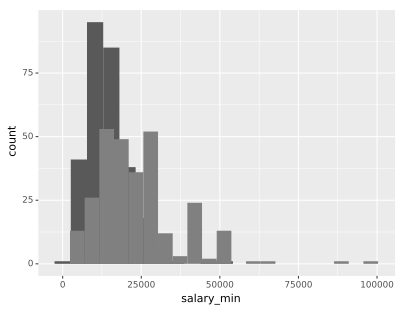

<ggplot: (146129160810)>

In [16]:
(ggplot(df_salary, aes('salary_min'))
 + geom_histogram()
 + geom_histogram(aes('salary_max'), fill = "grey")
)

工资下限集中在12500，而工资上限分布较宽，大概在两万左右吧~

有几个离群值非常地引人注目，居然还有月薪10万的！我们看看这个月薪10万的公司是谁~

In [17]:
(pd.concat([df_cleaned, df_salary], axis=1)
 [['companyId','companyFullName', 'companyShortName', 'salary_min', 'salary_max', 'positionName']]
 .sort_values(by="salary_max", ascending=False)
 .head()
)

,companyId,companyFullName,companyShortName,salary_min,salary_max,positionName
61,272572,深圳市康恩诺科技有限公司,康恩诺,50000.0,100000.0,资深大数据分析师
59,272572,深圳市康恩诺科技有限公司,康恩诺,45000.0,90000.0,资深数据分析经理
168,128065,深圳白骑士大数据有限公司,深圳白骑士大数据有限公司,38000.0,65000.0,数据分析总监
120,451,腾讯科技(深圳)有限公司,腾讯,30000.0,60000.0,pcg01-qq后台高级数据分析工程师
108,95529,深圳云天励飞技术有限公司,云天励飞,25000.0,50000.0,数据分析挖掘服务架构师/开发总监


排名第一的康恩诺科技公司是个生产家用医疗器械的公司，   
它在网上招聘的职位都是资深工程师一类的，感觉是新设立了一个大数据团队，然后正在招核心人员。

我们再来看看工资的区域分布情况

In [18]:
df_salary_map = pd.concat([df_cleaned[['longitude', 'latitude']], df_salary], axis=1)
df_salary_map[['longitude', 'latitude']] = df_salary_map[['longitude', 'latitude']].astype(float)
df_salary_map.head()

,longitude,latitude,salary_min,salary_max
0,113.946040,22.533413,10000.0,20000.0
1,114.110430,22.614636,15000.0,25000.0
2,0.000000,0.000000,15000.0,27000.0
3,113.940802,22.523714,20000.0,30000.0
4,113.940711,22.524429,15000.0,30000.0


看一下工资下限的区域分布

In [19]:
df_salary_map.describe()

,longitude,latitude,salary_min,salary_max
count,287.000000,287.000000,287.000000,287.000000
mean,108.541699,25.991408,13891.986063,24459.930314
std,21.759662,17.693286,6835.134339,12994.254943
min,0.000000,0.000000,2000.000000,4000.000000
25%,113.937945,22.530583,10000.000000,15000.000000
50%,113.946250,22.540853,15000.000000,22000.000000
75%,114.022919,22.549919,18000.000000,30000.000000
max,114.128931,116.331398,50000.000000,100000.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002205F3D18D0>,
      dtype=object)

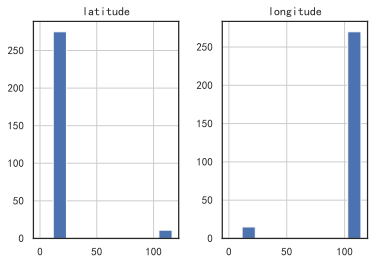

In [20]:
df_salary_map[['longitude', 'latitude']].hist()

我们可以看到经度和纬度都有奇怪的离群值，我们把这些离群值去除掉

In [21]:
df2_salary_map = df_salary_map.query('latitude < 50 & longitude > 100')

Text(0.5,1,'数据分析师工资（下限）在深圳的分布情况')

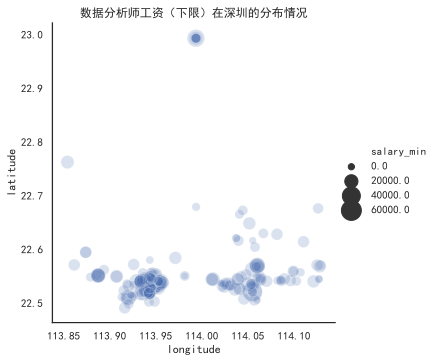

In [22]:
sns.relplot(x='longitude', y='latitude', size='salary_min', sizes=(40, 400),
           alpha=0.2, data=df2_salary_map)
plt.title(u'数据分析师工资（下限）在深圳的分布情况')
#plt.axis('off')

Text(0.5,1,'数据分析师工资（上限）在深圳的分布情况')

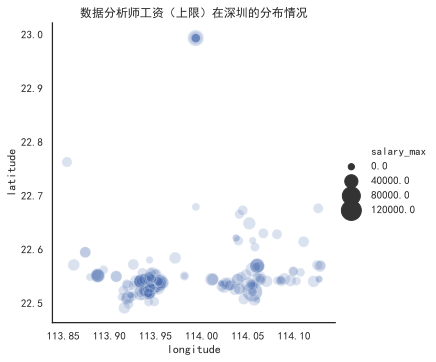

In [23]:
sns.relplot(x='longitude', y='latitude', size='salary_max', sizes=(40,400),
           alpha=0.2, data=df2_salary_map)
plt.title(u'数据分析师工资（上限）在深圳的分布情况')

看来职位也是主要分布在南山区和福区

没有找到一个可以直接将经纬度数据映射到地图中的包，所以没法直接在python中绘制数据地图。  
我会尝试在其他软件中绘制，比如powerbi

In [24]:
df2_salary_map.to_csv("salaries of lagou data analyst.csv", index=False,encoding='utf8')

下面就展示一下，通过powerbi绘制的工资（下限）分布热力图

![jupyter](./深圳数据分析师工资（下限）热力分布图.png)

我们再看看那些区域的工作需求多~  
字段`district`是企业自己标注的工作地点  
通过统计不同地点的数量，可以看到那里的就业岗位多

In [25]:
df_cleaned >> count('district', sort=True)

,district,n
0,南山区,186
1,福田区,67
2,宝安区,13
3,罗湖区,8
4,龙华新区,7
5,龙岗区,4


结果也是很明显，自然是南山的岗位多得多，毕竟是科技园区嘛。  
画个图：

Text(0.5,1,'深圳各个区数据分析师的招聘数量')

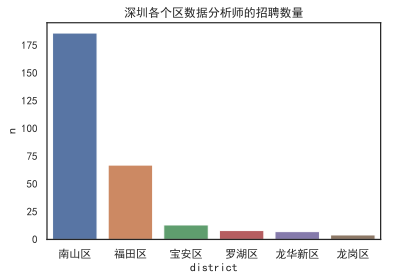

In [26]:
df_district = (df_cleaned >> count('district', sort=True))
sns.barplot(x='district', y='n', data=df_district)
plt.title("深圳各个区数据分析师的招聘数量")

### 工作经验要求

看一下对工作经验的要求：

In [27]:
df_workyear = (df_cleaned >> count('workYear', sort=True)
 >> define(percet = 'np.round(n / np.sum(n) * 100, 2)')
)
df_workyear

,workYear,n,percet
0,3-5年,118,41.11
1,1-3年,94,32.75
2,不限,29,10.10
3,5-10年,27,9.41
4,应届毕业生,14,4.88
5,1年以下,5,1.74


In [28]:
from pyecharts import Pie
pie = Pie('不同工作经验要求百分比')
pie.add(
    "",
    df_workyear.workYear,
    df_workyear.n,
    radius=[40, 75],
    is_label_show=True,
    legend_orient='vertical',
    legend_pos='right'
)

对经验的要求还是挺高的，工作经验大于3年的就占了一半。

### 行业分类

我们再来看看，都是什么行业在招数据分析师：

In [29]:
from pyecharts import WordCloud
from collections import Counter

def plot_wordcloud(df, field, fig_size=(600, 300)):
    df_word = df[[field]].dropna()
    df_word = df_word[field].str.strip()
    word_list = ','.join(list(df_word)).split(',')
    
    my_counter = Counter(word_list)
    name = []
    value = []
    for i, v in my_counter.items():
        name.append(i)
        value.append(v)
    
    width, height = fig_size
    
    wordcloud = WordCloud(width=600, height=300)
    wordcloud.add("", name, value, word_size_range=[20, 100],
                  shape='diamond')
    return wordcloud, name, value

wc, name, value = plot_wordcloud(df_cleaned, 'industryField')
wc

金融、电商、游戏占了大头，对数据分析师的需求量比较大。

### 学历要求

看看对学历的要求：

In [30]:
df_edu = (df_cleaned >> count('education', sort=True))
df_edu

,education,n
0,本科,234
1,硕士,24
2,大专,22
3,不限,7


整体来说对学历要求不高，本科起步就行了。

### 公司标签

companyLabelList似乎是每个公司对自己的描述，我们来看看各个公司都是怎么吹牛逼的😏  
但是我们观察到，每个公司的companyLabelList都是由好几个词组成的字符串，并通过逗号隔开。  
那我们就需要做些清洗。

In [31]:
wc_com_labels, com_labels, label_count = plot_wordcloud(df_cleaned, 'companyLabelList', fig_size=(1000, 800))
wc_com_labels

一眼望去，尽是“带薪年假”“绩效奖金”“年底双薪”“节日礼物”等等和金钱挂钩的奖励，突出了一个“财大气粗”！  
但诸如“周末双休”之类就排名排到10条街以后了😂。

看一下具体的排名

In [32]:
a_counter = Counter(dict(zip(com_labels, label_count)))
a_counter.most_common(5)

[('绩效奖金', 104), ('带薪年假', 96), ('节日礼物', 69), ('岗位晋升', 60), ('年度旅游', 45)]

### 技能要求

最后看看技能要求，我们对skillLables（不是我打错了，而是拉勾网的前端拼写错了😂）同样的画个词云图：

In [33]:
wc_skill, skills, skill_values = plot_wordcloud(df_cleaned, 'skillLables')
wc_skill

数据运营是被提及最多的技能，看来一般公司招聘数据分析师是来做运营的。  
其他的技能就SQL、SPSS等传统数据分析师常用的技能了，SQL、MySQL和SQLServer对应数据库，spss则是一款老牌统计软件，没想到需求量还这么大。  
但像算法之类的就很少提及了，看来主要任务也就是从数据库中调取数据、清洗数据了😂。

### 最后总结一下

总体来看，深圳的数据分析师工资较高，招聘薪资平均14k-24k，中位数15k-22k，其他的奖金激励应该也不少。  
从招聘工资的上限来看，数据分析师的发展潜力应该很大，最高薪资有开到100k一个月的~
目前来看主要工作机会在南山，同时南山的工资也要超过深圳的其他区。
工作经验要求较多，基本上工作经验超过3年的需求量很大，如果你1年经验都没有，那就很危险了。
而工作技能主要偏运营，采用较为传统的手段进行数据清洗和分析，其中SQL绝对是个不容忽视的技能。  
对数据分析师需求量较大的公司一般为金融和电商行业，具备金融和电商相关业务知识或经验，可以让你在些岗位的竞争中取得优势。